# Current clamp IV + Spikes

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Ih recordings in the "data/Dendrites" folder

In [2]:
data_folder = "data/14-free_day"

import os
print("Folders:")
for subdir in os.listdir(data_folder):
    if os.path.isdir(data_folder + "/" + subdir):
        print(f"'{data_folder}/{subdir}'")

from glob import glob
print("Files:")
data_files = glob(data_folder+"/*.abf")
data_files.sort()
data_files

Folders:
'data/14-free_day/paired soma-dendrite'
Files:


['data/14-free_day/iv_weird _neurons.abf',
 'data/14-free_day/spont_spikes_gapfree.abf']

Choose which file you want to analyze (copy name from above) and paste the file name here:

In [3]:
# data_file = 'data/11-Dendrites/2025_06_18_0039.abf'
data_file = 'data/14-free_day/iv_weird _neurons.abf'

Now we can load the file and plot the raw data:

Trace('iv_weird _neurons.abf')
Number of sweeps: 20
Points per sweep: 10,000
Duration per sweep: 1.000 s
Sampling rate: 10000 Hz
Sampling interval: 0.100 ms
Available channels: Current, Voltage


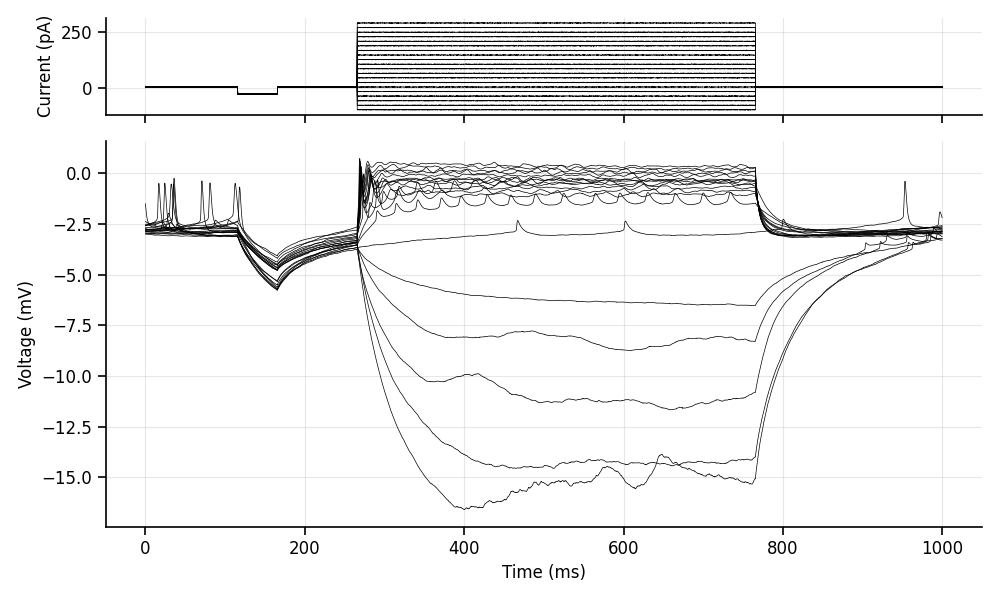

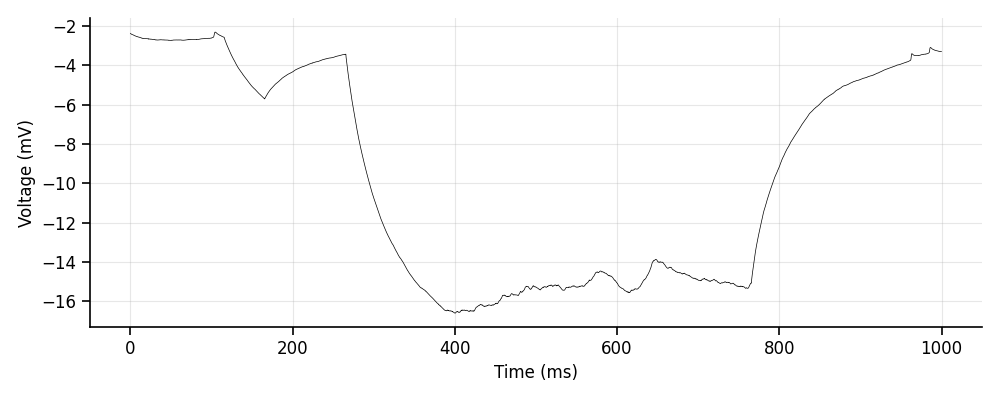

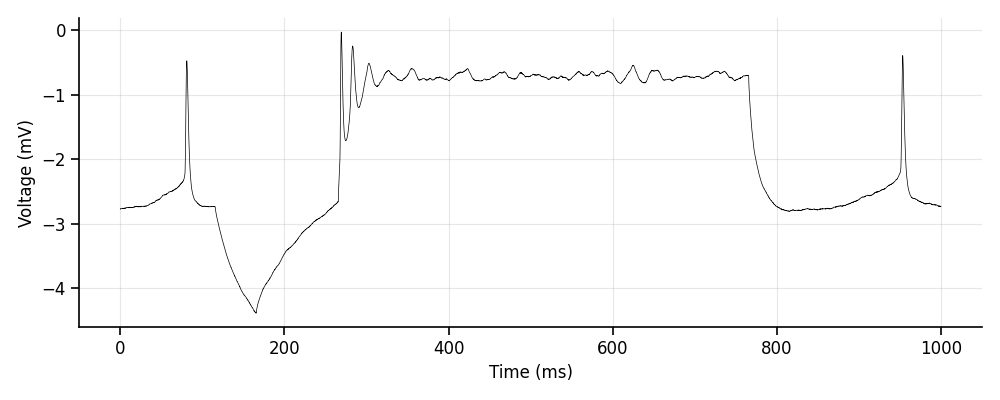

In [4]:
traces = Trace.from_axon_file(filename=data_file, 
                              load_voltage=True, 
                              load_ttl=False,
                              units=['pA', 'mV'])
print(traces)

traces.current_data, traces.voltage_data = traces.voltage_data, traces.current_data
traces.voltage_data = traces.voltage_data / 20

time_units = 'ms' # specify seconds (s), or milliseconds (ms)

# ----------------------------------------------------------------------------------------------------------------
%matplotlib widget
ax = traces.plot(plot_voltage=True, time_units=time_units, sweep='all', height_ratios=[1,4])
plt.show()

ax = traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, sweep=0)
plt.show()

ax = traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, sweep=traces.num_sweeps//2)
plt.show()

## 2. Signal processing

### Apply baseline correction

If your baseline current is not at zero, run the next code blocks to apply a baseline correction.

In [5]:
# Change this to True if you want to subtract the baseline from the sweeps.
subtract_baseline = True
start_baseline = 0
end_baseline = 115

BASELINE SUBTRACTED:
Baseline voltages: [-2.6382 -2.7238 -2.9581 ... -2.7246 -2.7113 -2.6761]


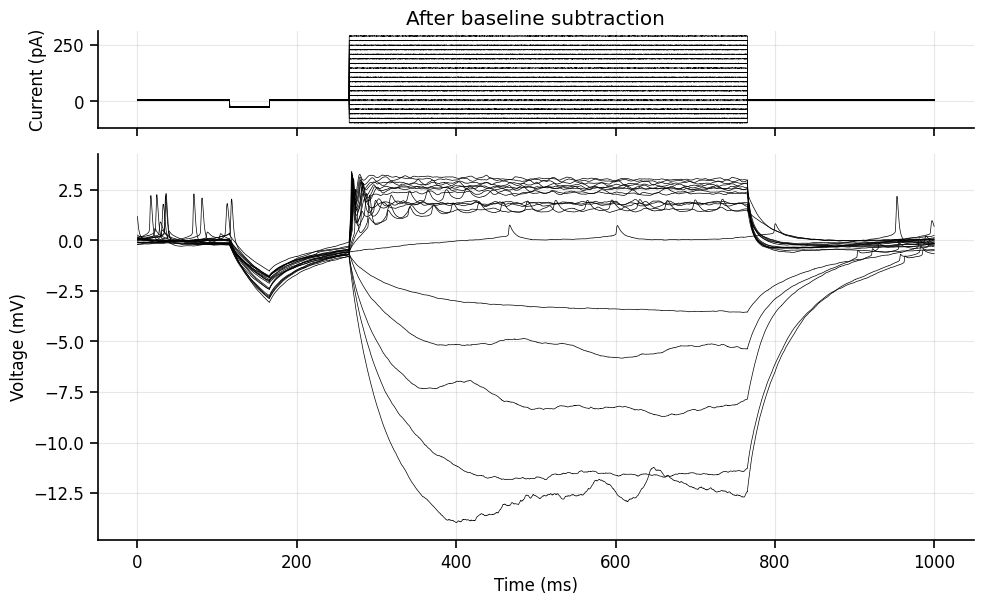

In [6]:
if subtract_baseline:
    traces.subtract_baseline(start_time = start_baseline, 
                             end_time = end_baseline , 
                             time_units = time_units,  # specify seconds (s), or milliseconds (ms)
                             channel = 'voltage')  # Options: 'current', 'voltage', 'all'
    %matplotlib inline
    ax1, ax2 = traces.plot(plot_voltage=True, plot_ttl=False, time_units=time_units, sweep='all', height_ratios=[1,4])
    ax1.set_title('After baseline subtraction', y=0.98)
    plt.show()
else:
    print("BASELINE NOT SUBTRACTED")


## 2. Measure Sag potential (caused by $I_{H}$ current)

### 2.1. Define the time window for the peak measurement

First we need to measure the peak voltage of the sag potential.

In [7]:
# 1. Get the time of the negative current step
holding_current = traces.current_data[0,0]
step_start = traces.get_step_events(threshold=holding_current-5, channel='current', edge='rising', polarity='negative', time_units=time_units, sweep=0)
step_end = traces.get_step_events(threshold=holding_current-5, channel='current', edge='falling', polarity='negative', time_units=time_units, sweep=0)

step_start = step_start[1]
step_end = step_end[1]
print("Double check that these numbers look correct:")
print(f"Step start: {step_start} {time_units}")
print(f"Step end: {step_end} {time_units}")

Double check that these numbers look correct:
Step start: 265.6 ms
Step end: 765.6 ms


#### The markers here will define where we will measure the steady-state potential:

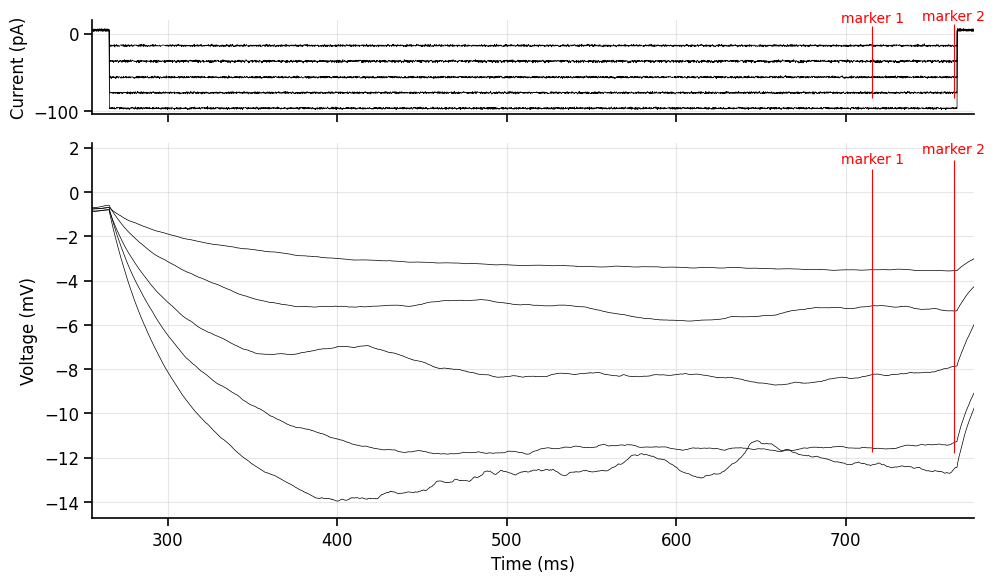

In [8]:
# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = step_end - 50
marker_2 = step_end - 2
sweeps_to_plot = [0,5] # Enter the range

# ----------------------------------------------------------------------------------------------------------------------
%matplotlib inline
ax1,ax2 = traces.plot(plot_voltage=True, time_units=time_units, marker_1=marker_1, marker_2=marker_2, sweep=sweeps_to_plot, height_ratios=[1,4])
ax1.set_xlim(step_start-10,step_end+10)
ax2.set_xlim(step_start-10,step_end+10)
plt.show()

#### Now we can measure the peak Sag and steady-state for each sweep

In [9]:
# 1. Measure the Sag peak
measurement_type = 'peak' # Options: 'mean', 'max', 'min', 'peak'

_, peak_voltage = traces.get_measurements(start_time=step_start+5, end_time=step_end-5,
                                                    measurement_type=measurement_type, time_units=time_units)
if np.all(peak_voltage == peak_voltage[0]):
    print("WARNING: All voltage steps are the same")

# 2. Measure the steady state voltage
measurement_type = 'mean' # Options: 'mean', 'max', 'min', 'peak'

current_steps, ss_voltage = traces.get_measurements(start_time=marker_1, end_time=marker_2,
                                                    measurement_type=measurement_type, time_units=time_units)
if np.all(ss_voltage == ss_voltage[0]):
    print("WARNING: All voltage steps are the same")
if np.all(current_steps == current_steps[0]):
    print("WARNING: All current steps are the same")

# %matplotlib inline
# sweep_idx = range(0,9)
# current_steps = current_steps[sweep_idx]
# voltage_steps = voltage_steps[sweep_idx]
# ax = plot_IV(voltage_steps, current_steps)# ,xlabel_coords=(0.95,0.25),ylabel_coords=(0.35,0.6))
# ax.set_title(f'Sag peak voltage vs current step')
# plt.show()

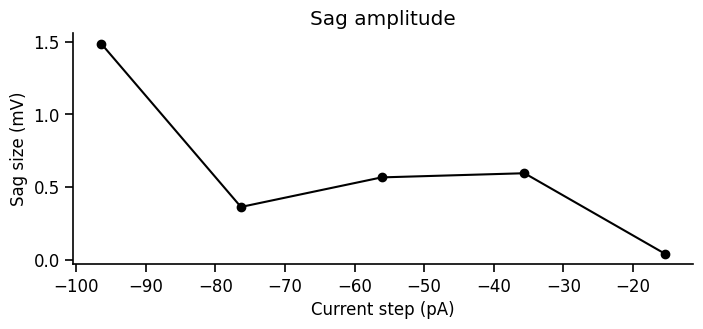

In [10]:
sag_size = np.abs(peak_voltage - ss_voltage)
sweeps_to_plot = range(sweeps_to_plot[0], sweeps_to_plot[1])

sag_size = sag_size[sweeps_to_plot]
x_axis = current_steps[sweeps_to_plot]

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x_axis, sag_size, marker='o', color='black')
ax.set_xlabel(f'Current step ({traces.current_unit})')
ax.set_ylabel(f"Sag size ({traces.voltage_unit})")
ax.set_title(f"Sag amplitude")
plt.show()


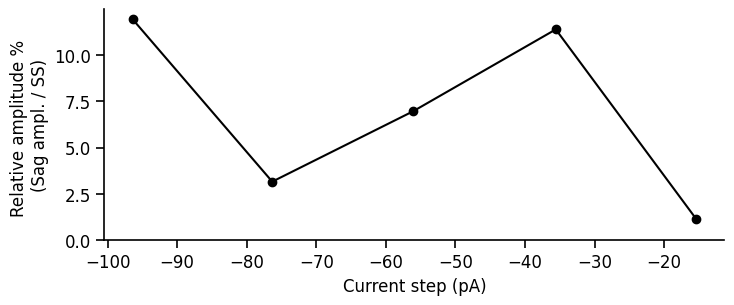

In [11]:
sag_size = np.abs(peak_voltage - ss_voltage) / np.abs(ss_voltage)
sag_size = sag_size[sweeps_to_plot]

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x_axis, sag_size*100, marker='o', color='black')
ax.set_xlabel(f'Current step ({traces.current_unit})')
ax.set_ylabel(f"Relative amplitude % \n(Sag ampl. / SS)")
ax.set_ylim(bottom=0)
plt.show()


## 3. Measure firing rate to get FI curve

In [13]:
traces_during_stim = traces.crop(timepoint=step_start, timepoint_2=step_end, time_units=time_units)

In [35]:
spike_results = traces_during_stim.analyze_action_potentials(min_spike_amplitude=0.5, 
                                                         max_width=10.0, 
                                                         min_ISI=1.0, 
                                                         headstage=0, 
                                                         sweep=None, # None means all sweeps
                                                         return_dict=True)

spike_results[-1]

{'spike_times': array([1.7]),
 'threshold_voltages': array([1.1319]),
 'peak_voltages': array([3.4024]),
 'spike_amplitudes': array([2.2705]),
 'spike_widths': array([4.4])}

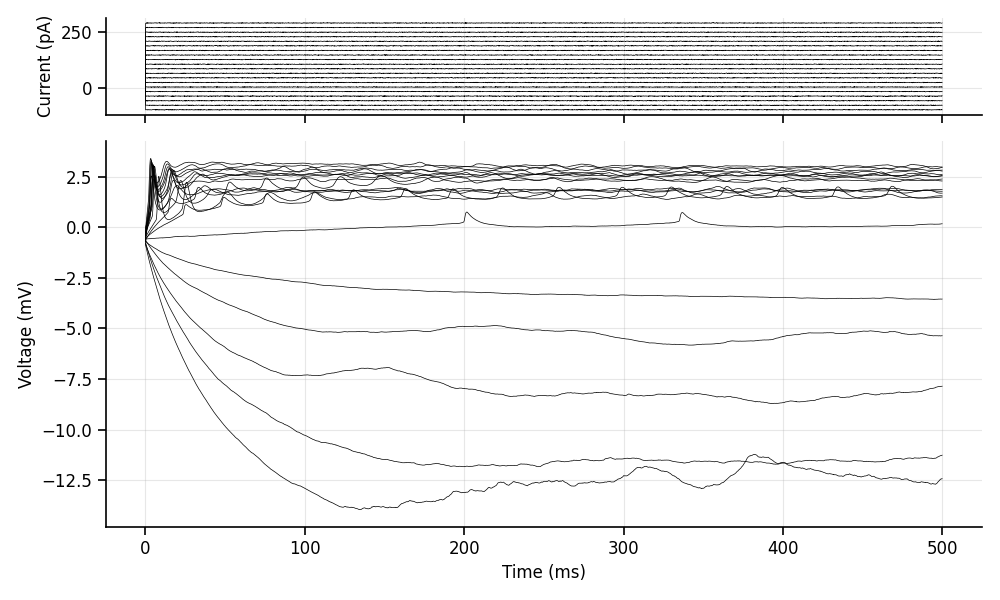

In [36]:
%matplotlib widget
ax1, ax2 = traces_during_stim.plot(plot_voltage=True, plot_ttl=False, time_units=time_units, sweep='all', height_ratios=[1,4])
plt.show()

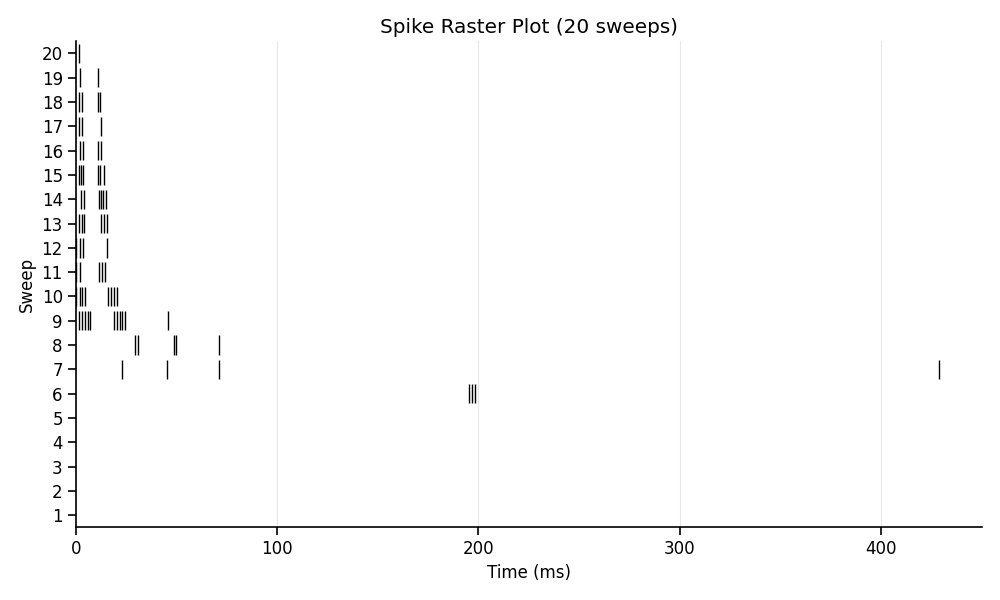

In [37]:
fig,ax = plot_spike_raster(spike_results, sweep_duration=None, time_units='ms', 
                      marker_height=0.8, marker_width=1.0, figsize=(10, 6),
                      title=None, xlabel=None, ylabel='Sweep', 
                      color='black', alpha=1.0, ax=None)

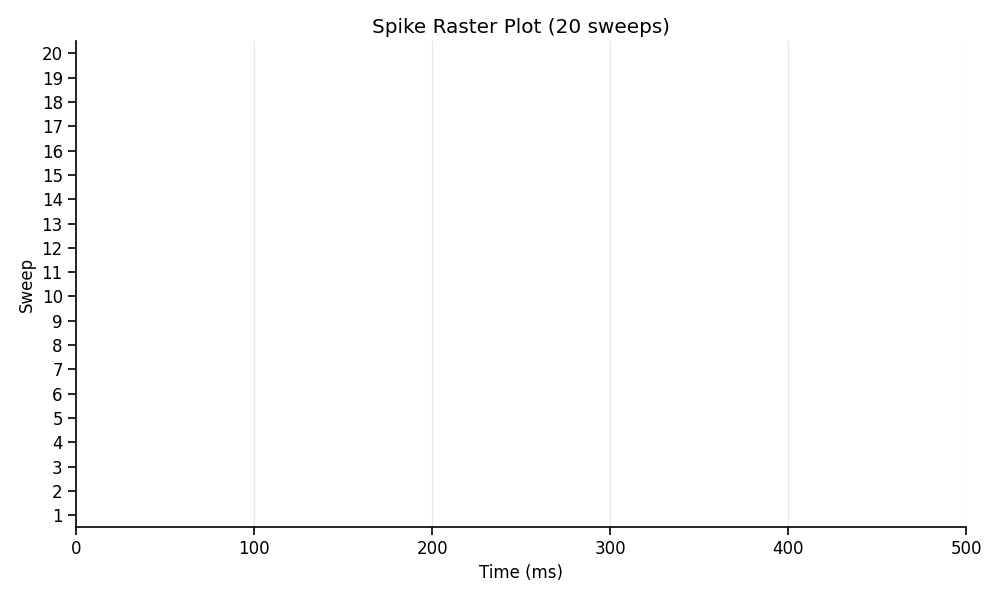

In [38]:
fig,ax =  plot_spike_raster_from_trace(traces_during_stim, min_spike_amplitude=5.0, max_width=10.0, 
                                min_ISI=1.0, headstage=0)

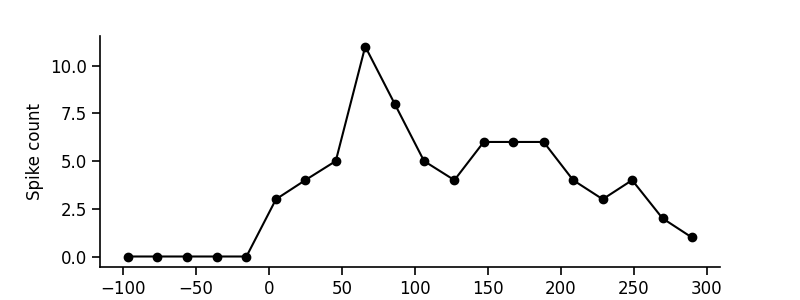

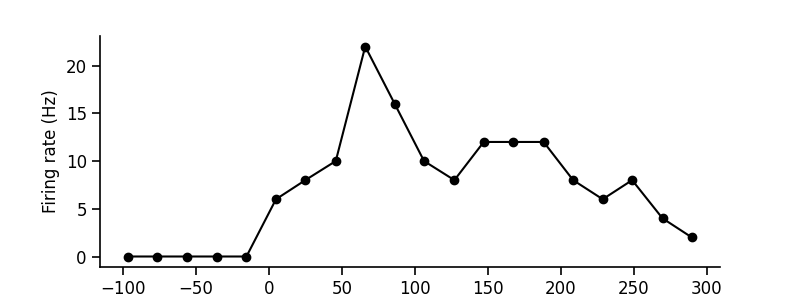

In [42]:
spike_counts, stats = get_spike_counts(spike_results, return_stats=True)

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(current_steps, spike_counts, '-o', color='black')
ax.set_xlabel(f'Current step ({traces.current_unit})')
ax.set_ylabel('Spike count')
# ax.set_ylim(bottom=-1)
plt.show()

total_time_s = traces_during_stim.total_time
firing_rate = spike_counts / total_time_s
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(current_steps, firing_rate, '-o', color='black')
ax.set_xlabel(f'Current step ({traces.current_unit})')
ax.set_ylabel('Firing rate (Hz)')
# ax.set_ylim(bottom=-2)
plt.show()


Spike Property Summary:
--------------------------------------------------
Total spikes analyzed: 72

Peak Voltages (mV):
  Mean ± SD: 2.5 ± 0.6
  Range: [0.8, 3.4]

Spike Amplitudes (mV):
  Mean ± SD: 1.5 ± 0.8
  Range: [0.5, 2.9]

Spike Widths (ms):
  Mean ± SD: 6.34 ± 2.19
  Range: [2.60, 9.90]


(<Figure size 1200x400 with 3 Axes>,
 array([<AxesSubplot: title={'center': 'Peak Voltages'}, xlabel='Peak Voltages (mV)', ylabel='Count'>,
        <AxesSubplot: title={'center': 'Spike Amplitudes'}, xlabel='Spike Amplitudes (mV)', ylabel='Count'>,
        <AxesSubplot: title={'center': 'Spike Widths'}, xlabel='Spike Widths (ms)', ylabel='Count'>],
       dtype=object),
 {'peak_voltages': {'mean': 2.514838085082418,
   'std': 0.5705379823038348,
   'min': 0.7521548063858696,
   'max': 3.4024087657099185,
   'n': 72},
  'spike_amplitudes': {'mean': 1.4775382147894964,
   'std': 0.7785443480174444,
   'min': 0.50048828125,
   'max': 2.886962890625,
   'n': 72},
  'spike_widths': {'mean': 6.344444444444445,
   'std': 2.187139741057617,
   'min': 2.6000000000000005,
   'max': 9.9,
   'n': 72}})

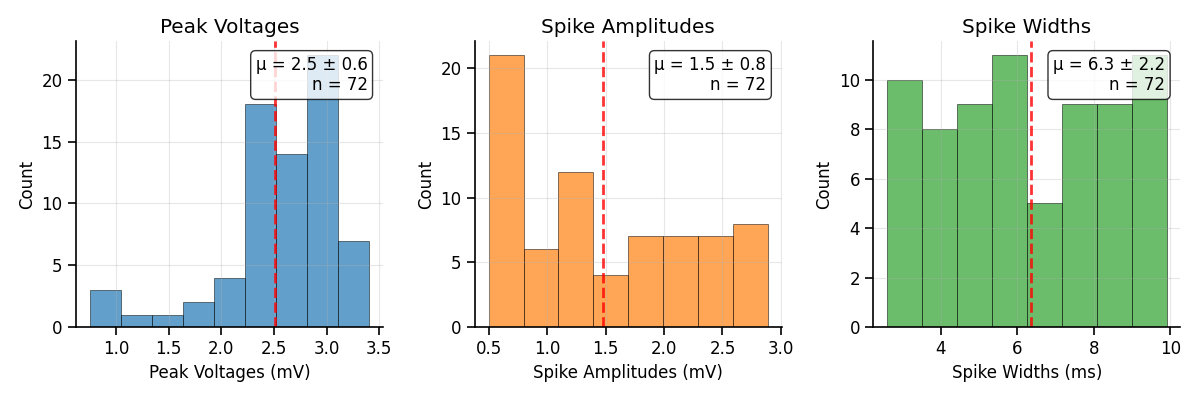

In [43]:
plot_spike_histograms(spike_results)